In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from scipy.stats import percentileofscore
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dat = pd.read_table('predictions/probabilities_py.tsv')

In [3]:
dat.head(2)

,compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
0,DB00282,Pamidronate,DOID:11476,osteoporosis,DM,1,0.03893,0.896067,0.979216,1,1.00000,NaN,NaN,NaN
1,DB00630,Alendronate,DOID:11476,osteoporosis,DM,1,0.03893,0.893901,0.978742,1,0.99935,NaN,NaN,NaN


In [4]:
print('Training Positives:', dat['status'].fillna(0).sum())
#print('PKDB Positives:', dat['status_pkdb'].fillna(0).sum())
print('Drugcentral Positives:', dat['status_drugcentral'].fillna(0).sum())
print('Trials Positives:', dat['status_trials'].fillna(0).sum())

Training Positives: 755
Drugcentral Positives: 208.0
Trials Positives: 5594.0


In [5]:
metrics = ['status', 'status_drugcentral', 'status_trials']
auroc_results = defaultdict(dict)
name_map = {'status': 'Training Set', 'status_pkdb': 'PharmacotherapyDB', 
            'status_drugcentral': 'Drug Central', 'status_trials': 'Clinical Trials'}

for metric in metrics:

    df = dat[[metric, 'prediction']].dropna().sort_values('prediction')
    
    fpr, tpr, thresh = roc_curve(df[metric], df['prediction'])
    
    auroc_results[metric]['fpr'] = fpr
    auroc_results[metric]['tpr'] = tpr
    auroc_results[metric]['thresh'] = thresh
    auroc_results[metric]['auc'] = auc(fpr, tpr)
        

In [6]:
sns.set_style('whitegrid')

/home/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


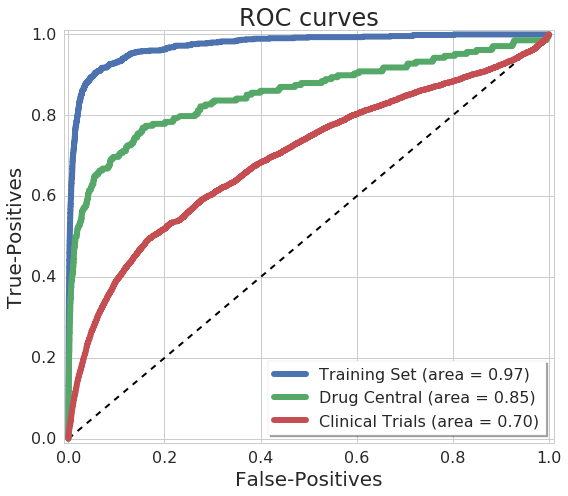

In [7]:
lw = 6

x = [i for i in np.arange(0.0,1.01,.01)]
plt.plot(x,x, 'k--', lw = lw-4)

for metric in metrics:
    plt.plot(auroc_results[metric]['fpr'], auroc_results[metric]['tpr'], lw=lw,
             label='{0} (area = {1:0.2f})'
                 .format(name_map[metric], auroc_results[metric]['auc']))

fig = plt.gcf()
fig.set_size_inches(8, 7)
fig.set_tight_layout(True)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('False-Positives', size=20)
plt.ylabel('True-Positives', size=20)
plt.title('ROC curves', size=24)
plt.legend(loc="lower right", frameon=True, shadow=True, prop={'size':16})
plt.savefig('figure/ROC-Curves_py.png', dpi=300)

In [8]:
pr_results = defaultdict(dict)


for metric in metrics:

    df = dat[[metric, 'prediction']].dropna().sort_values('prediction')
    
    pre, rec, thresh = precision_recall_curve(df[metric], df['prediction'])
    
    pr_results[metric]['pre'] = pre
    pr_results[metric]['rec'] = rec
    pr_results[metric]['thresh'] = thresh
    pr_results[metric]['avg'] = average_precision_score(df[metric], df['prediction'])
        

/home/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


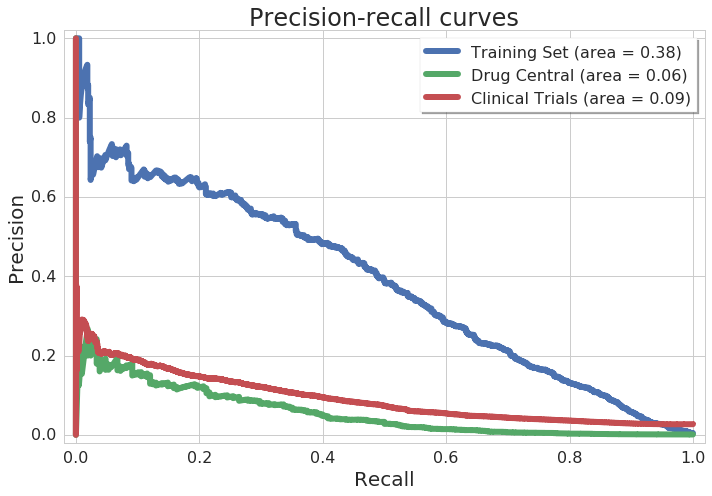

In [9]:
for metric in metrics:
    plt.plot(pr_results[metric]['rec'], pr_results[metric]['pre'], lw=lw,
             label='{0} (area = {1:0.2f})'
                 .format(name_map[metric], pr_results[metric]['avg']))

fig = plt.gcf()
fig.set_size_inches(10, 7)
fig.set_tight_layout(True)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.title('Precision-recall curves', size=24)
plt.legend(loc="upper right", frameon=True, shadow=True, prop={'size':16})
plt.savefig('figure/PR-Curves_py.png', dpi=300)

In [10]:
# Get all the predicitons
prediction = sorted(dat['prediction'].values)

In [12]:
n = len(prediction)

In [15]:
def calc_percentile(df, calc_col='prediction'):
    """
    Quick calculation of percentile as sorted_order / total_numb_of_obs
    """
    
    total = len(df)
    
    order = (dat.sort_values('prediction')     # sort
                .reset_index()                 # reset index to get sorterd order
                .reset_index()                 # Turn sorted index into new column
                .rename(columns={'level_0':'order'})  # Rename new sorted index column column 'order'
                .set_index('index')            # Reset the old index
                .sort_index())['order']        # sort by original index nad return order
    order.index = order.index.rename(None)     # Remove new name of index

    return ((order+1) / total)*100

In [16]:
dat['predictile'] = calc_percentile(dat)

In [17]:
# Reshape the data for easy violin plotting
predictile = []
for metric in metrics:
    sub_df = dat.query('{} == 1'.format(metric))['predictile'].reset_index(drop=True).to_frame()
    sub_df['metric'] = name_map[metric]
    predictile.append(sub_df)
predictile = pd.concat(predictile)

/home/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


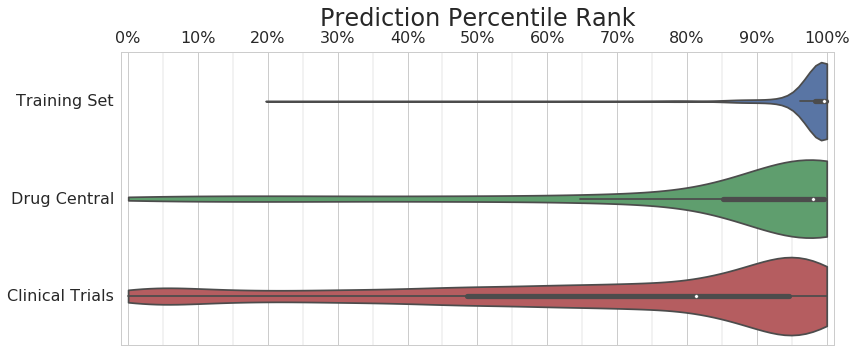

In [18]:
fig = sns.violinplot(x='predictile', y='metric', data=predictile, scale='width', cut=0)

fig = plt.gcf()
fig.set_size_inches(12, 5)
fig.set_tight_layout(True)
plt.xlabel('Prediction Percentile Rank', size = 24)
plt.yticks(size=16)
plt.xticks(np.arange(0, 101, 10))
plt.xlim(-1, 101)
plt.axes().set_xticklabels([str(x)+'%' for x in range(0, 101, 10)], size=16)
plt.axes().set_ylabel('')
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))
plt.axes().xaxis.grid(b=True, which='minor', color='k', linewidth=0.1)
plt.axes().xaxis.tick_top()
plt.axes().xaxis.set_label_position('top')
plt.savefig('figure/predictile_py.png', dpi=300);